In [281]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quadrature, quad
import numpy.random as rand
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML

from lib.lif import LIF, ParamsLIF, LIF_3layer, ParamsLSM, LSM

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'rand', 'rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Test the three layer network

In [2]:
params = ParamsLIF(n = 10)
lif = LIF_3layer(params)

In [3]:
vh, hh, vo, ho, sh, sx = lif.simulate([1,1])
ho.shape

(1, 1000)

In [4]:
sh.shape

(10, 1000)

## Learn XOR function

In [330]:
mm = 1000
fi_min = -6
fi_max = 50
Is = np.linspace(fi_min, fi_max, mm)
fI = np.zeros(Is.shape)
V_th = 1
V_r = 0
V_rest = 0
sigma = 20
tau_m = 1

In [373]:
for idx,I in enumerate(Is):
    y_th = (V_th - V_rest - I)/sigma
    y_r  = (V_r -  V_rest - I)/sigma
    f = lambda u: np.divide(np.multiply(np.exp(-u**2),np.exp(2*y_th*u)-np.exp(2*y_r*u)),u)
    a=quad(f, 0.1, np.infty)[0]
    if np.isfinite(a):
        fI[idx] = 1/(tau_m*a)
        
_fI_prime = np.hstack((0,np.diff(fI)))

def fI_prime(I):
    if isinstance(I, np.ndarray):
        I[I < fi_min] = fi_min
        I[I > fi_max] = fi_max
    else:
        I = float(I)
        if I < fi_min:
            I = fi_min
        if I > fi_max:
            I = fi_max
    return _fI_prime[np.ceil(mm*(I-fi_min)/(fi_max-fi_min)).astype(int)-1]

/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


In [374]:
#np.float(np.array([3,4])-fi_min)/(fi_max-fi_min)
#np.float(np.array([3,4]))
fI_prime(np.arange(20)+40)

array([ 0.11610398,  0.11827064,  0.120463  ,  0.12268161,  0.12480158,
        0.12707286,  0.12937206,  0.13169971,  0.13405638,  0.13644262,
        0.13885897,  0.13885897,  0.13885897,  0.13885897,  0.13885897,
        0.13885897,  0.13885897,  0.13885897,  0.13885897,  0.13885897])

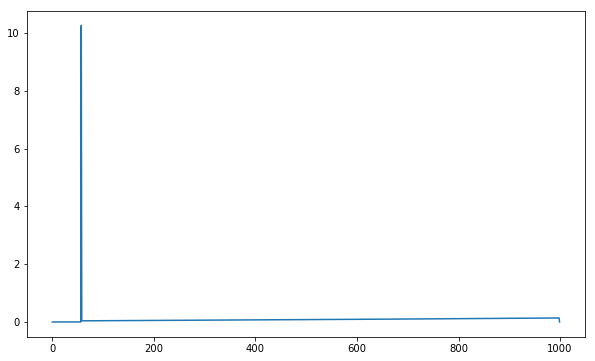

In [333]:
plt.plot(fI_prime)

In [392]:
N = 1000             # Number of episodes
n = 10              # Number of hidden neurons
q = 100             # Number of LSM neurons
tau_s = 0.020       # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 1               # Time for each episode
eta = 10            # RDD learning rate
epsilon = 200        # Weight learning rate

params = ParamsLIF(n = n)
lif = LIF_3layer(params)
params = ParamsLSM(q = q, p = 2, t = t)
lsm = LSM(params)

t_filter = np.linspace(0, 0.15, 150)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

def xor(x):
    return x[0] != x[1]

#Simulate episode
Vo = np.zeros((1, q))
Vh = np.zeros((n, q))

inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]
nI = len(inputs)

#Save learning progress
mean_cost = np.zeros(N)
mean_output = np.zeros(N)

Whist = np.zeros((lif.W.shape[0], lif.W.shape[1], N))
Uhist = np.zeros((lif.U.shape[0], lif.U.shape[1], N))
Vohist = np.zeros((Vo.shape[0], Vo.shape[1], N))
Vhhist = np.zeros((Vh.shape[0], Vh.shape[1], N))

alpha = -200
beta = 100

betahist = np.zeros((1, N))

wmax = 10000
umax = 400

for idx in range(N):
    #Choose input at random
    #x_input = np.random.rand(2)<0.5
    #Cycle through inputs
    x_input = np.array(inputs[idx%4])
    
    #Simulate system
    (vh, hh, vo, ho, sh, sx) = lif.simulate(x_input)
    s_lsm = lsm.simulate(10*np.mean(sx,1))
    so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
    #Compute cost function
    dcost = alpha if xor(x_input) else beta
    cost = dcost*so
    #Run through and apply RDD online
    dVo = np.zeros(Vo.shape)
    dVh = np.zeros(Vh.shape)
    dW = np.zeros(lif.W.shape)
    dU = np.zeros(lif.U.shape)
    nSo = 0
    nSh = np.zeros(n)
    bto = False
    bth = [False]*n
    for t in range(vh.shape[1]):
        #Update RD weights for output neuron
        if (vo[0,t] > mu - p) & (vo[0,t] < mu):
            if bto == False:
                dVo[0,:] += (np.dot(Vo[0,:], s_lsm[:,t])+cost[t])*s_lsm[:,t]
                bto = True
        elif (vo[0,t] < mu + p) & (vo[0,t] >= mu):
            #Only do the update when firing...
            if bto == True:
                dVo[0,:] += (np.dot(Vo[0,:], s_lsm[:,t])-cost[t])*s_lsm[:,t]
                Vo[0,:] = Vo[0,:] - eta*dVo[0,:]#*N/(N+1)
                dVo[0,:] = np.zeros((1,q))
                bto = False         
        #Update weights for output layer
        if vo[0,t] > mu:
            dU[0,:] += np.dot(Vo[0,:], s_lsm[:,t])*sh[:,t]*fI_prime(np.dot(lif.U[0,:], sh[:,t]))
            nSo += 1
            #Or use the true gradient...
            #dU[0,:] += dcost*sh[:,t]
            #pass
                        
        for k in range(n):
            #Update RD weights for hidden neurons
            if (vh[k,t] > mu - p) & (vh[k,t] < mu):
                if bth[k] == False:
                    dVh[k,:] += (np.dot(Vh[k,:], s_lsm[:,t])+cost[t])*s_lsm[:,t]
                    bth[k] = True
            elif (vh[k,t] < mu + p) & (vh[k,t] >= mu):
                #Only do the update when firing...
                if bth[k] == True:
                    dVh[k,:] += (np.dot(Vh[k,:], s_lsm[:,t])-cost[t])*s_lsm[:,t]
                    Vh[k,:] = Vh[k,:] - eta*dVh[k,:]#*N/(N+1)
                    dVh[k,:] = np.zeros((1,q))
                    bth[k] = False
            #Update weights for hidden neurons
            if vh[k,t] > mu:
                #print "Updating dW"
                dW[k,:] += np.dot(Vh[k,:], s_lsm[:,t])*sx[:,t]*fI_prime(np.dot(lif.W[k,:], sx[:,t]))
                nSh[k] += 1
                #Or use the 'true' gradient...
                #But maybe this is wrong
                #If this worked we could 
                #dW[k,:] += dcost*lif.U[0,k]*sx[:,t]
                #pass
                
    #Only do weight updates at end of episode, could also do online...
    #for k in range(n):
    #    if nSh[k]:
    #        lif.W[k,:] += -epsilon*dW[k,:]/nSh[k]
    
    if nSo:
        lif.U += -epsilon*dU/nSo
    
    #Bound the weights
    lif.W = np.maximum(np.minimum(lif.W, wmax), -wmax)
    lif.U = np.maximum(np.minimum(lif.U, umax), -umax)
    
    Whist[:,:,idx] = lif.W
    Uhist[:,:,idx] = lif.U
    Vhhist[:,:,idx] = Vh
    Vohist[:,:,idx] = Vo
    betahist[0,idx] = np.mean(np.dot(Vo[0,:], s_lsm))

    mean_cost[idx] = np.mean(cost)
    mean_output[idx] = np.mean(so)

(10, 2)

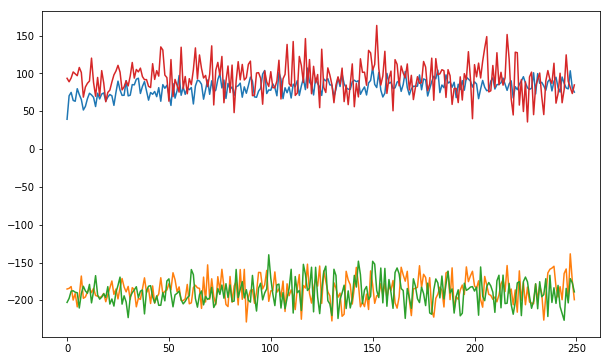

In [393]:
plt.plot(2*betahist.reshape((-1,4))/ds)
betahist.shape
lif.W.shape

This works pretty well actually...

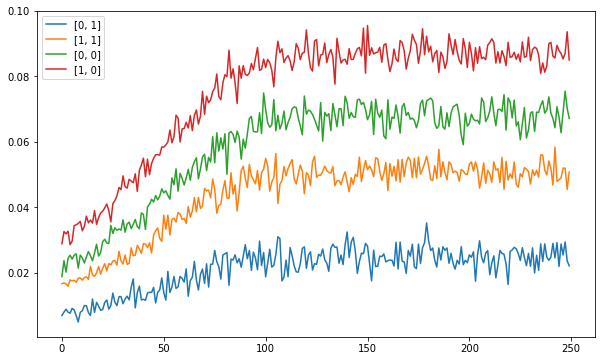

In [394]:
#Plot the output for each of the 4 inputs
#plt.plot(mean_cost)
#mean_cost.shape

fig,ax = plt.subplots(1,1)
ax.plot(mean_output[range(0,  N,   nI)], 'C0')
ax.plot(mean_output[range(1,  N+1, nI)], 'C1')
ax.plot(mean_output[range(2,  N+2, nI)], 'C2')
ax.plot(mean_output[range(3,  N+3, nI)], 'C3')
ax.legend({'[0, 0]','[0, 1]','[1, 0]','[1, 1]'})

(1, 10, 1000)

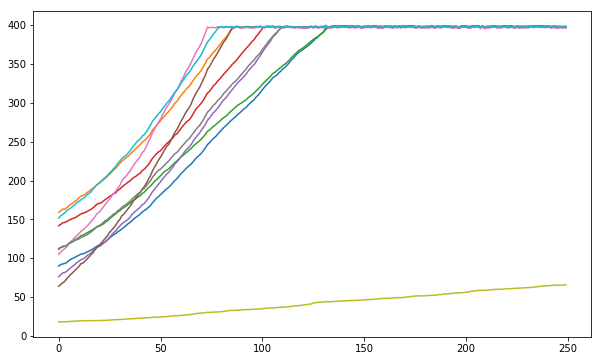

In [395]:
#Plot what the weights are doing
fig,ax = plt.subplots(1,1)
#ax.plot(Whist[:,0,range(0,  N,   nI)].T)
ax.plot(Uhist[0,:,range(0,  N,   nI)])
#ax.set_ylim([-1500, 500])
Uhist.shape

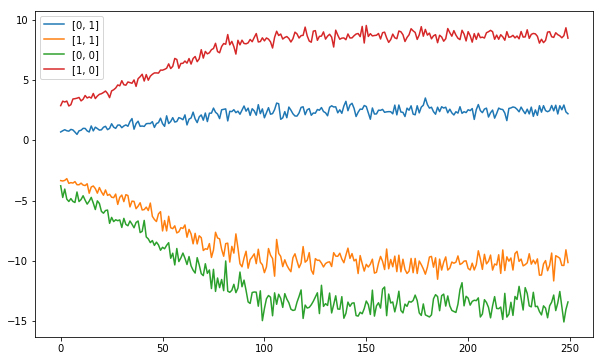

In [397]:
fig,ax = plt.subplots(1,1)
ax.plot(mean_cost[range(0,  N,   nI)], 'C0')
ax.plot(mean_cost[range(1,  N+1, nI)], 'C1')
ax.plot(mean_cost[range(2,  N+2, nI)], 'C2')
ax.plot(mean_cost[range(3,  N+3, nI)], 'C3')
ax.legend({'[0, 0]','[0, 1]','[1, 0]','[1, 1]'})

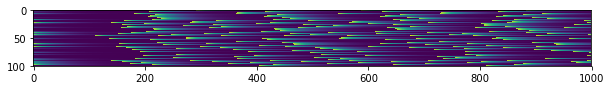

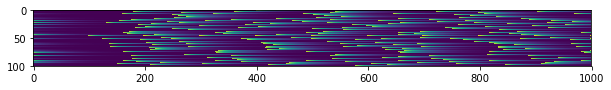

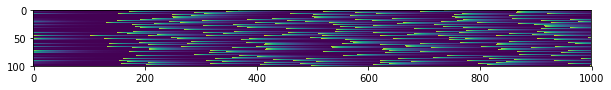

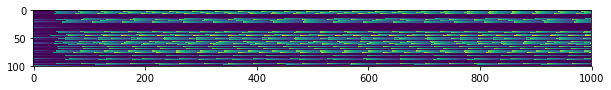

In [105]:
fig,ax = plt.subplots(1,1)
x_input = [0, 0]
(vh, hh, vo, ho, sh, sx) = lif.simulate(x_input)
s_lsm = lsm.simulate(np.mean(sx, 1))
ax.imshow(s_lsm)

fig,ax = plt.subplots(1,1)
x_input = [1, 0]
(vh, hh, vo, ho, sh, sx) = lif.simulate(x_input)
s_lsm = lsm.simulate(np.mean(sx, 1))
ax.imshow(s_lsm)

fig,ax = plt.subplots(1,1)
x_input = [0, 1]
(vh, hh, vo, ho, sh, sx) = lif.simulate(x_input)
s_lsm = lsm.simulate(np.mean(sx, 1))
ax.imshow(s_lsm)

fig,ax = plt.subplots(1,1)
x_input = [1, 1]
(vh, hh, vo, ho, sh, sx) = lif.simulate(x_input)
s_lsm = lsm.simulate(10*np.mean(sx, 1))
ax.imshow(s_lsm)

In [103]:
(vh, hh, vo, ho, sh, sx) = lif.simulate([0,0])
print(np.mean(sx, 1))
(vh, hh, vo, ho, sh, sx) = lif.simulate([0,1])
print(np.mean(sx, 1))
(vh, hh, vo, ho, sh, sx) = lif.simulate([1,0])
print(np.mean(sx, 1))
(vh, hh, vo, ho, sh, sx) = lif.simulate([1,1])
print(np.mean(sx, 1))

[ 0.04893394  0.04340561]
[ 0.04872229  0.19004   ]
[ 0.18933278  0.04338447]
[ 0.20414644  0.19303324]


## Checking basic features of the network

I need to:

* make the network balanced. Done, since this only applies to the LSM
* plot activity diagnostics
* implement standard backprop learning, to make sure that works
* turn off the weight learning, and check the RDD rule is doing ok for fixed weights
* Make LSM input the filtered spiking input

### 1. Activity diagnostics

In [2]:
params = ParamsLIF(n = 10)
lif = LIF_3layer(params)

x0 = 50.000000
x1 = 50.000000


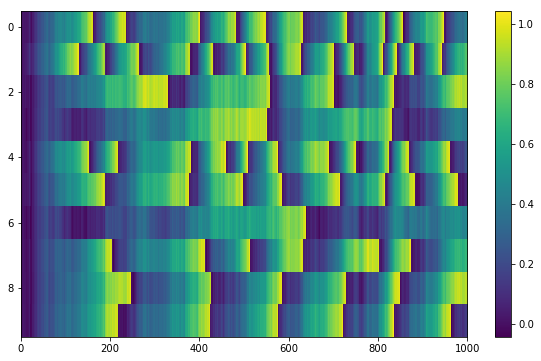

In [9]:
vh, hh, vo, ho, sh, sx = lif.simulate([0,0])
a=plt.imshow(vh, aspect = 'auto')
plt.colorbar(a)

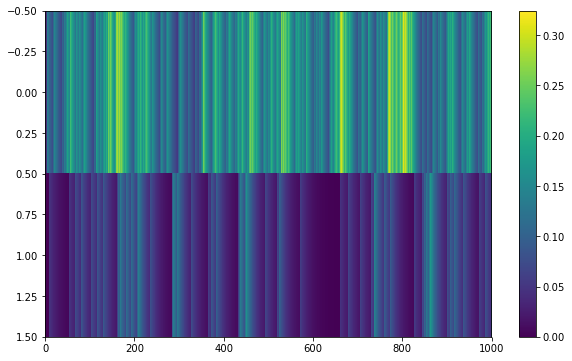

In [4]:
a=plt.imshow(sx, aspect = 'auto')
plt.colorbar(a)

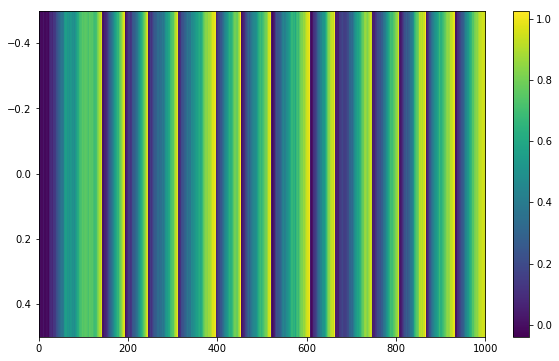

In [5]:
a=plt.imshow(vo, aspect = 'auto')
plt.colorbar(a)

In [4]:
lif.W

array([[  54.73524742,  177.18569684],
       [  70.01149485,  120.48067787],
       [ 144.27385411,   59.61055671],
       [ 117.13743381,   12.19279431],
       [ 135.29011415,  178.81358984],
       [  56.44784004,  189.00637505],
       [ 189.02739855,  165.68069886],
       [ 106.35132401,  155.66292058],
       [ 191.6465091 ,  123.76376557],
       [  85.14546218,   79.07636199]])

In [23]:
lif.U

array([[ 43.17554572, -24.6420282 ,  51.94976389, -24.50573762,
         19.49779564, -51.53652518, -60.83369757,   0.22489635,
         61.45785809,  53.30331854]])

## The theoretical firing rate function and its derivative


In [325]:
mm = 1000
Is = np.linspace(-6, 20, mm)
fI = np.zeros(Is.shape)
V_th = 1
V_r = 0
V_rest = 0
sigma = 20
tau_m = 1

In [326]:
for idx,I in enumerate(Is):
    y_th = (V_th - V_rest - I)/sigma
    y_r = (V_r - V_rest - I)/sigma
    f = lambda u: np.divide(np.multiply(np.exp(-u**2),np.exp(2*y_th*u)-np.exp(2*y_r*u)),u)
    a=quad(f, 0.1, np.infty)[0]
    if np.isfinite(a):
        fI[idx] = 1/(tau_m*a)

/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


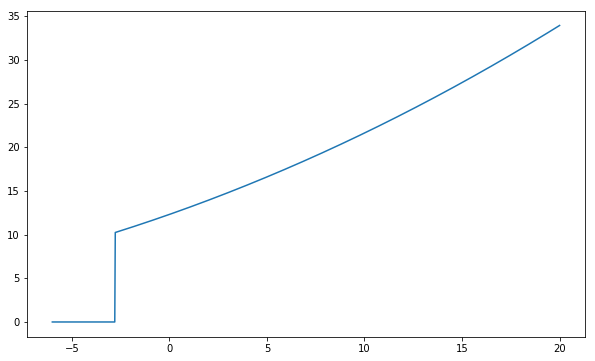

In [329]:
plt.plot(Is, fI)
#plt.plot(Is, np.hstack((np.diff(fI), 0)))

In [298]:
np.isfinite(s)

NameError: name 's' is not defined